# Unit Commitment with Pyomo

## Collecting the data and creating the typical days profiles

In [1]:
from optimization_test import *
plt.show()

C:\Users\Lorenzo\Desktop\prova modello python\optimization_test.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Demands = demands.as_matrix()
C:\Users\Lorenzo\Desktop\prova modello python\optimization_test.py:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,ii+1)
C:\Users\Lorenzo\Desktop\prova modello python\optimization_test.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to eac

<Figure size 640x480 with 3 Axes>

C:\Users\Lorenzo\Desktop\prova modello python\optimization_test.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1)
C:\Users\Lorenzo\Desktop\prova modello python\optimization_test.py:122: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2)


<Figure size 640x480 with 3 Axes>

Importing Pyomo and other modules

In [2]:
from pyomo.environ import *
import numpy as np
from matplotlib.pyplot import *

Defeining the demand and the electricity generated from the PV for each typical days

In [3]:
t=24 # parameter to set the dimension of the problem
# Demands profiles
EE_demand   = typ_profiles[0:t, 0]
Heat_demand = typ_profiles[0:t, 1]
Cold_demand = typ_profiles[0:t, 2]
PV_output = typ_profiles[0:t, 3] # kW/m2

Defining all parameters needed for the model

In [4]:
# Fuels prices [€/kWh]
Fuels = {
    'NG': 0.0258,
    'Diesel':  1
    }

# Available area [m2] for PV panels
PV_area=10
PV_gen=PV_area*PV_output # kW

# Electricity prices [€/kWh] # può essere usato anche un profilo <--
El_price = 0.3

# Variation penalty cost [€]
var_pen = 8

# Heat producers parameters. Defined as a dictionary
# Fuel: price related to the fuel.
# goods: goods produced by the machines
# m and q parameters: machines goods curve coefficients (straight lines, el=electricity, th=thermal)
# min/max_In: energy input range
# RU/RDlim: are the ramp up/down limits related to the machines (maximum load variation between two time steps)
# RUSU/RDSD: ramp limits related to start-up (SU) and shut-down (SD) of the machines (max load variation between
# time steps when machine start from switched-off condition)
# Dissipable_Heat: True if Heat can be dissipated into atmosphere. NOTE: just for heat producing machines
# Internal: True if it can consume internal goods (e.g. compressor chiller can use energy produced by other machiens)
# NOTE: machines that can consume goods produced by other machiens have fuel cost null. There is a constraint that defines the
# machine inoput as the sum of the bought electricity and the produced one

# --> in futuro aggiungere anche il tipo di macchina e il numero di priorità
Machines_parameters = {
    'Boiler1': { 'In': 'NG', 'fuel cost': Fuels['NG'], 'goods':       ['Heat'],    'm_th': 0.976, 'q_th': -57.6,   'm_el':   0.0, 'q_el':    0.0, 'min_In':  450, 'max_In': 1800, 'RUlim': 1000, 'RDlim': 10000, 'RUSU': 1800, 'RDSD': 1800, 'minUT': 2, 'minDT': 0, 'OM':  2, 'Dissipable_Heat': False, 'Internal Consumer': False },
    'Boiler2': { 'In':     'NG', 'fuel cost': Fuels['NG'], 'goods':       ['Heat'],    'm_th': 0.976, 'q_th': -57.6,   'm_el':   0.0, 'q_el':    0.0, 'min_In':  450, 'max_In': 1800, 'RUlim': 1000, 'RDlim': 10000, 'RUSU': 1800, 'RDSD': 1800, 'minUT': 2, 'minDT': 0, 'OM':  2, 'Dissipable_Heat': False, 'Internal Consumer': False },
    'ICE1':    { 'In': 'NG', 'fuel cost': Fuels['NG'], 'goods': ['Heat', 'El'],    'm_th': 0.490, 'q_th': -201.72, 'm_el': 0.439, 'q_el': -106.2, 'min_In': 2144, 'max_In': 4288, 'RUlim': 4288, 'RDlim': 10000, 'RUSU': 4288, 'RDSD': 4288, 'minUT': 6, 'minDT': 0, 'OM': 19, 'Dissipable_Heat':  True, 'Internal Consumer': False },
    #'ICE2':    { 'In': 'NG', 'fuel cost': Fuels['NG'], 'goods': ['Heat', 'El'],    'm_th': 0.490, 'q_th': -201.72, 'm_el': 0.439, 'q_el': -106.2, 'min_In': 2144, 'max_In': 4288, 'RUlim': 4288, 'RDlim': 10000, 'RUSU': 4288, 'RDSD': 4288, 'minUT': 6, 'minDT': 0, 'OM': 19, 'Dissipable_Heat':  True, 'Internal Consumer': False },
    # 'CC':      { 'In': 'El', 'fuel cost':           0, 'goods':       ['Cold'],    'm_th': 3.500, 'q_th':    0.00, 'm_el': 0.000, 'q_el':    0.0, 'min_In':    0, 'max_In': 5000, 'RUlim': 1000, 'RDlim': 10000, 'RUSU': 5000, 'RDSD': 5000, 'minUT': 2, 'minDT': 0, 'OM':  2, 'Dissipable_Heat': False, 'Internal Consumer':  True }
    }

Storage_parameters = {
     # thermal energy storage
     'TES1': { 'good': 'Heat', 'minC': 0, 'maxC': 1274, 'Init%': 0, 'eta_ch': 1, 'eta_disch': 1, 'eta_sd': 0.995, 'PmaxIn': 5000, 'PmaxOut': 5000, 'FinCval': 0.0001, 'OMxTP': 0.0001 }
     }

# Time values
# Number of time intervals
T =t

## Creating the Pyomo concrete model

In [5]:
######################################################################################################################################################################
# Optimization Model #################################################################################################################################################

# Create model as ConcreteModel
model = ConcreteModel()


Creating Set

In [6]:
## SETS
# Set of all time intervals - in this case must be 504
model.times = RangeSet( 0, T - 1 )

# Set of all the machines
model.Machines = Set( initialize = Machines_parameters.keys() )
model.Storages = Set ( initialize= Storage_parameters.keys() )
list_Machine_heat = []
list_Machine_el = []
list_Machine_diss=[]
for i in Machines_parameters.keys():
    if Machines_parameters[i]['Dissipable_Heat']:
        list_Machine_diss.append(i)
    if 'Heat' in Machines_parameters[i]['goods']:                               # aggiungere qua le righe per anche Cold <--
        list_Machine_heat.append(i)
        if 'El' in Machines_parameters[i]['goods']:
            list_Machine_el.append(i)
    elif 'El' in Machines_parameters[i]['goods']:
        list_Machine_el.append(i)
model.Machines_heat = Set( within = model.Machines, initialize = list_Machine_heat )
model.Machines_el = Set( within = model.Machines, initialize = list_Machine_el )
model.Machines_diss= Set( within=model.Machines, initialize=list_Machine_diss)

Creating Variables

In [7]:
## VARIABLES

# Machines Variables
# Fuel as input of the machines related to the amout at the i-th time for the j-th machine
# Fuel input as power [kW]
model.fuel_In = Var( model.Machines, model.times, domain = NonNegativeReals)

# On/off variable
model.z = Var( model.Machines, model.times, domain = Binary )
# Delta on/off
model.delta_on = Var (model.Machines, model.times, domain=Binary)
model.delta_off = Var (model.Machines, model.times, domain=Binary)

# Variable for Q and El produced
model.Qprod = Var( model.Machines_heat, model.times, domain=NonNegativeReals)
model.Elprod = Var( model.Machines_el, model.times, domain=NonNegativeReals)

# Useful variables
model.Quseful = Var( model.Machines_heat, model.times, domain=NonNegativeReals)
model.Eluseful= Var( model.Machines_el, model.times, domain=NonNegativeReals)

# Variable for Q dissipated
model.Qdiss = Var( model.Machines_diss, model.times, domain=NonNegativeReals)

# Electricity purch/sold to the network at time t
model.el_purch = Var ( model.times, domain=NonNegativeReals)
model.el_sold = Var ( model.times, domain=NonNegativeReals)

# Heat Storage level
model.l = Var (model.Storages, model.times, domain=NonNegativeReals)
model.l[('TES1',0)].fix(0)  # storage start level = 0
# Storage charge/discharge power
model.power_in = Var (model.Storages, model.times, domain=Reals)
model.power_out = Var (model.Storages, model.times, domain=Reals)

Defining the Objective Function

In [8]:
## OBJECTIVE FUNCTION
def ObjFun( model ):
    return sum(model.fuel_In[i,j]*Machines_parameters[i]['fuel cost']
               for i in model.Machines for j in model.times) + sum(
                       (model.el_purch[j]-model.el_sold[j]) for j in model.times)

model.obj = Objective(
    rule = ObjFun,
    sense = minimize
    )

Defining Constraints

In [9]:
## CONSTRAINTS

# Machines Constraints
# Machines range constraint
# Machines on/off binary constraint
# nota: li puoi aggregare in un unico vincolo

# Min/Max energy input constraint
def machines_rule_min( model, i, j ):
    return  model.fuel_In[i,j] >= Machines_parameters[i]['min_In']*model.z[i,j]
model.machine_constr_min=Constraint(model.Machines, model.times, rule=machines_rule_min)
def machines_rule_max( model, i, j ):
    return  model.fuel_In[i,j] <= Machines_parameters[i]['max_In']*model.z[i,j]
model.machine_constr_max=Constraint(model.Machines, model.times, rule=machines_rule_max)

# Rump Up/Down constraint
# Set of all time excluding zero: model.times_not0=model.times-[0]
def machines_RupLim_rule( model, i, j):
    if j==0:
        return Constraint.Skip
    return model.fuel_In[i,j] - model.fuel_In[i, j-1] <= Machines_parameters[i]['RUlim']
model.RupLim_constr=Constraint(model.Machines, model.times, rule=machines_RupLim_rule)

def machines_RdLim_rule( model, i, j):
    if j==0:
        return Constraint.Skip
    return model.fuel_In[i,j-1] - model.fuel_In[i, j] <= Machines_parameters[i]['RDlim']
model.RdLim_constr=Constraint(model.Machines, model.times, rule=machines_RdLim_rule)

# Delta on variable definition
def delta_on_rule1( model, i, j):
    if j==0:
        return model.delta_on[i,j]==0
    return model.delta_on[i,j] >= (model.z[i,j]-model.z[i,j-1])
model.delta_on_constr1=Constraint(model.Machines, model.times, rule=delta_on_rule1)
def delta_on_rule2( model, i, j):
    if j==0:
        return Constraint.Skip
    return model.delta_on[i,j] <= 1 - model.z[i,j-1]
model.delta_on_constr2=Constraint(model.Machines, model.times, rule=delta_on_rule2)
def delta_on_rule3( model, i, j):
    return model.delta_on[i,j] <= model.z[i,j]
model.delta_on_constr3=Constraint(model.Machines, model.times, rule=delta_on_rule3)

# Delta off variable definition
def delta_off_rule1( model, i, j):
    if j==0:
        return model.delta_off[i,j]==0
    return model.delta_off[i,j] >= (model.z[i,j-1]-model.z[i,j])
model.delta_off_constr1=Constraint(model.Machines, model.times, rule=delta_off_rule1)
def delta_off_rule2( model, i, j):
    if j==0:
        return Constraint.Skip
    return model.delta_off[i,j] <= 1 - model.z[i,j]
model.delta_off_constr2=Constraint(model.Machines, model.times, rule=delta_off_rule2)
def delta_off_rule3( model, i, j):
    if j==0:
        return Constraint.Skip
    return model.delta_off[i,j] <=  model.z[i,j-1]
model.delta_off_constr3=Constraint(model.Machines, model.times, rule=delta_off_rule3)


# Min UP/DOWN time constraint
def min_up_rule(model, i, j):
    if j < Machines_parameters[i]['minUT']:
        return Constraint.Skip
    return sum(model.z[i,t] for t in range(j-Machines_parameters[i]['minUT'], j)
               ) >= Machines_parameters[i]['minUT']*model.delta_off[i,j]
model.MinUT_constr=Constraint(model.Machines, model.times, rule=min_up_rule)

def min_down_rule(model, i, j):
    if Machines_parameters[i]['minDT']==0:
        return Constraint.Skip
    if j < Machines_parameters[i]['minDT']:
        return Constraint.Skip
    return sum((1-model.z[i,t]) for t in range(j-Machines_parameters[i]['minDT'], j)
               ) >= Machines_parameters[i]['minDT']*model.delta_on[i,j]
model.MinDT_constr=Constraint(model.Machines, model.times, rule=min_down_rule)




# Function to obtain heat/cold produced by machines
def heat_production(model, i, j ):
    return  model.fuel_In[i,j]*Machines_parameters[i]['m_th'] + model.z[i,j]*Machines_parameters[i]['q_th']
# Function to obtain elecricity produced by machines
def el_production(model, i, j ):
    return  model.fuel_In[i,j]*Machines_parameters[i]['m_el'] + model.z[i,j]*Machines_parameters[i]['q_el']

def Qprod_rule(model, i, j):
    return model.Qprod[i, j] == heat_production(model,i,j)
model.Qprod_constr=Constraint(model.Machines_heat, model.times, rule=Qprod_rule)

def Elprod_rule(model, i, j):
    return model.Elprod[i, j] == el_production(model,i,j)
model.Elprod_constr=Constraint (model.Machines_el, model.times, rule=Elprod_rule)

'''
# Q prod/useful constraint
def heat_us_rule( model, i, j ):
    return model.Quseful[i, j] <= model.Qprod[i, j]
model.Heat_us_constr = Constraint(model.Machines_heat, model.times, rule = heat_us_rule)
'''

# El prod/useful constraint
def el_us_rule( model, i, j ):
    return model.Eluseful[i, j] == model.Elprod[i, j]
model.el_us_constr = Constraint(model.Machines_el, model.times, rule = el_us_rule)

# Q useful constraint: useful heat if generated but not dissipated
# A constraint that the system uses to define Q diss each time step
def heat_diss_rule( model, i, j ):
    if Machines_parameters[i]['Dissipable_Heat']:
        return model.Quseful[i, j] == model.Qprod[i, j] - model.Qdiss[i, j]
    return model.Quseful[i, j] == model.Qprod[i, j]
model.Heat_diss_constr = Constraint(model.Machines_heat, model.times, rule = heat_diss_rule)



# Storage Capacity constraint
def stor_capacity_rule( model, s, j):
    return model.l[s, j] <= Storage_parameters[s]['maxC']
model.stor_capacity_constr = Constraint(model.Storages ,model.times, rule=stor_capacity_rule)

# Storage Power constraint
def stor_powerIn_rule ( model, s, j):
    if j==0:
        return model.power_in[s,j] == model.l[s,j]/1
    return model.power_in[s,j] == (model.l[s,j]-model.l[s,j-1])/1  # kWh/h = kW
model.stor_powerIn_constr = Constraint(model.Storages, model.times, rule=stor_powerIn_rule)
def stor_powerOut_rule ( model, s, j):
    if j==0:
        return model.power_out[s,j] == -model.l[s,j]/1
    return model.power_out[s,j] == -(model.l[s,j]-model.l[s,j-1])/1  # kWh/h = kW
model.stor_powerOut_constr = Constraint(model.Storages, model.times, rule=stor_powerOut_rule)

# Storage level link
def stor_link_rule(model, s):
    return model.l[s,0]==model.l[s,T-1]
model.stor_link_constr = Constraint(model.Storages, rule=stor_link_rule)



# Heat balance constraint rule
def heat_balance_rule( model, j, s ):
    if j==0:
        return sum( model.Quseful[i, j] for i in model.Machines_heat ) == Heat_demand[j]
    return sum( model.Quseful[i, j] for i in model.Machines_heat ) -(model.l[s, j]-model.l[s, j-1]) == Heat_demand[j]
# Heat Balance
model.Heat_balance_constr = Constraint(
    model.times, model.Storages,
    rule = heat_balance_rule
    )

# Electricity balance constrint rule
def el_balance_rule( model, j ):
    return sum( model.Eluseful[i, j] for i in model.Machines_el ) + model.el_purch[j] - model.el_sold[j] +PV_gen[j]== EE_demand[j]
# Electricity Balance
model.El_balance_constr = Constraint(
    model.times,
    rule = el_balance_rule
    )

Solving the model

In [10]:
## Solve PROBLEM
model.solver=SolverFactory('glpk')
results = model.solver.solve(model, options={'mipgap':0.05}, tee=True) # tee=True to display solver output in console

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.05 --write C:\Users\Lorenzo\AppData\Local\Temp\tmpucp3cefd.glpk.raw
 --wglp C:\Users\Lorenzo\AppData\Local\Temp\tmpjqvo1fzh.glpk.glp --cpxlp C:\Users\Lorenzo\AppData\Local\Temp\tmp15tg62m8.pyomo.lp
Reading problem data from 'C:\Users\Lorenzo\AppData\Local\Temp\tmp15tg62m8.pyomo.lp'...
C:\Users\Lorenzo\AppData\Local\Temp\tmp15tg62m8.pyomo.lp:6652: warning: lower bound of variable 'x73' redefined
C:\Users\Lorenzo\AppData\Local\Temp\tmp15tg62m8.pyomo.lp:6652: warning: upper bound of variable 'x73' redefined
1081 rows, 624 columns, 2656 non-zeros
216 integer variables, all of which are binary
6868 lines were read
Writing problem data to 'C:\Users\Lorenzo\AppData\Local\Temp\tmpjqvo1fzh.glpk.glp'...
5726 lines were written
GLPK Integer Optimizer, v4.65
1081 rows, 624 columns, 2656 non-zeros
216 integer variables, all of which are binary
Preprocessing...
2 hidden packing inequaliti(es) were detected
126 

## Analizing and Plotting results

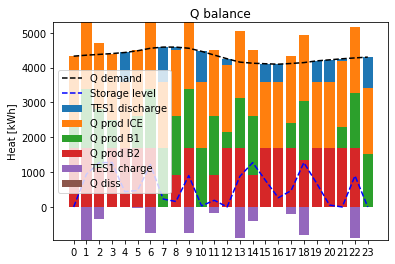

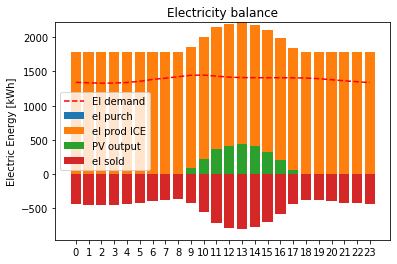

In [11]:
model.solutions.load_from(results)

F_In=[]
z=[]
Q_prod=[]
El_prod=[]
Q_us=[]
El_us=[]
Q_diss=[]
el_purch=[]
el_sold=[]
stor_lev=[]
power_in=[]
power_out=[]
delta_on=[]
delta_off=[]
var_list=[F_In ,z , delta_on, delta_off, Q_prod, El_prod, Q_us, El_us, Q_diss, el_purch, el_sold, stor_lev, power_in, power_out]

i = 0
for v in model.component_objects(Var, active=True):
    #print ("Variable",v)
    for index in v:
        #print('  ', index, value(v[index]))
        var_list[i].append(value(v[index]))
    i=i+1

z_B1=np.array(z[0:T])
z_B2=np.array(z[T:2*T])
z_ICE1=np.array(z[2*T:3*T])

Q_prod_B1=np.array(Q_prod[0:T])
Q_prod_B2=np.array(Q_prod[T:2*T])
Q_prod_ICE1=np.array(Q_prod[2*T:3*T])

Q_us_B1=np.array(Q_us[0:T])
Q_us_B2=np.array(Q_us[T:2*T])
Q_us_ICE1=np.array(Q_us[2*T:3*T])

El_prod_ICE1=np.array(El_prod)
El_us_ICE1=np.array(El_us)

Q_diss=-np.array(Q_diss)
el_purch=np.array(el_purch)
el_sold=-np.array(el_sold)

Q_charge=[0]
Q_discharge=[0]

for i in range(1, len(stor_lev)):
    diff=stor_lev[i]-stor_lev[i-1]
    if diff >=0:
        Q_charge.append(diff)
        Q_discharge.append(0)
    else:
        Q_discharge.append(diff)
        Q_charge.append(0)

stor_l=np.array(stor_lev)
Q_charge=-np.array(Q_charge)
Q_discharge=-np.array(Q_discharge)


H_day=24
times_step=np.arange(H_day)
Fig_Q=plt.figure()
plt.xticks(times_step, list(times_step))
plt.ylabel("Heat [kWh]")
plt.title("Q balance")
plt.bar(times_step, Q_discharge[0:H_day], bottom=Q_prod_B1[0:H_day]+ Q_prod_B2[0:H_day] + Q_prod_ICE1[0:H_day], label='TES1 discharge')
plt.bar(times_step, Q_prod_ICE1[0:H_day],  bottom=Q_prod_B1[0:H_day]+ Q_prod_B2[0:H_day], label='Q prod ICE')
plt.bar(times_step, Q_prod_B1[0:H_day], bottom=Q_prod_B2[0:H_day], label='Q prod B1')
plt.bar(times_step, Q_prod_B2[0:H_day], label='Q prod B2')
plt.bar(times_step, Q_charge[0:H_day], label='TES1 charge')
plt.bar(times_step, Q_diss[0:H_day], bottom=Q_charge[0:H_day], label='Q diss')

plt.plot(times_step, np.array(Heat_demand[0:H_day]), 'k--', label='Q demand')
plt.plot(times_step, stor_l[0:H_day], 'b--', label='Storage level')
plt.legend()
#plt.show()


#fig_El, ax_El=plt.subplots()
Fig_E=plt.figure()
#plt.subplot(122)
plt.xticks(times_step, list(times_step))
plt.ylabel("Electric Energy [kWh]")
plt.title("Electricity balance")
plt.bar(times_step, el_purch[0:H_day], bottom=PV_gen[0:H_day]+El_us_ICE1[0:H_day], label='el purch')
plt.bar(times_step, El_prod_ICE1[0:H_day], bottom=PV_gen[0:H_day], label='el prod ICE')
plt.bar(times_step, PV_gen[0:H_day], label='PV output')
plt.bar(times_step, el_sold[0:H_day], label='el sold')

plt.plot(times_step, np.array(EE_demand[0:H_day]), 'r--', label='El demand')
plt.legend()
plt.show()
